In [2]:
import h5py
from scipy import ndimage

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
folder = "/global/cscratch1/sd/jialiu/BABAMAS"
f = h5py.File(folder+"/Mnu_0_WMAP9_cone_0_kappa_zs_1p0.hdf5", 'r')
g = h5py.File(folder+"/Mnu_0_DMONLY_WMAP9_cone_0_kappa_zs_1p0.hdf5", 'r')

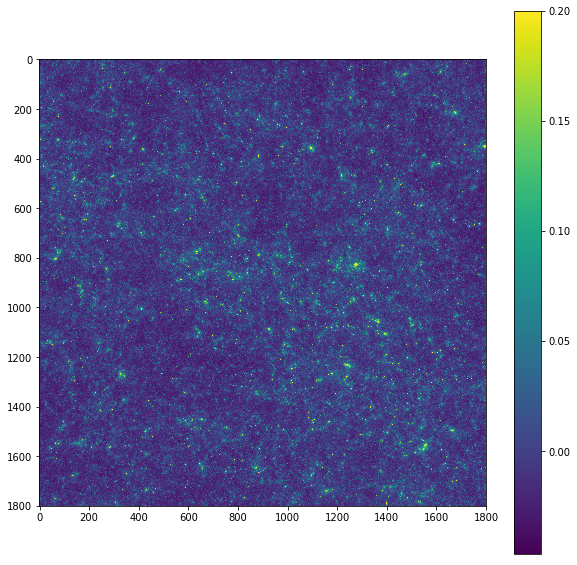

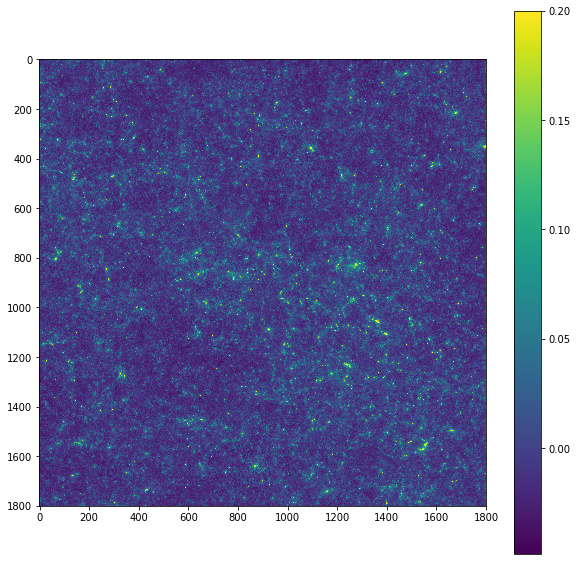

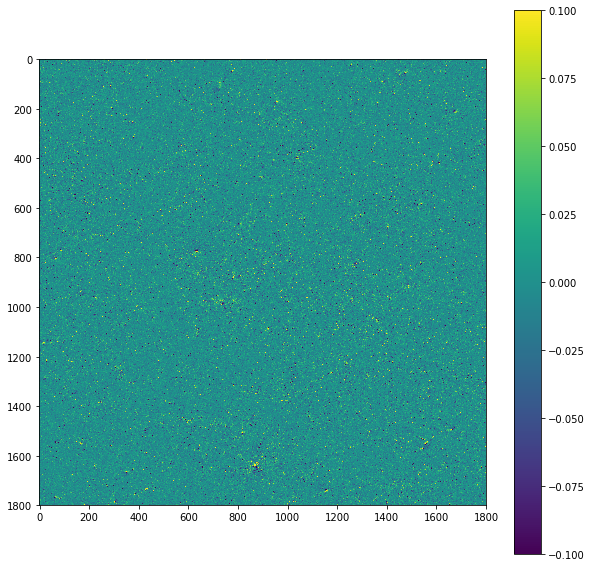

In [5]:
plt.figure(figsize=(10,10))

imshow(f["kappa_zs_1_ran0"],vmax=0.2)
colorbar()
plt.show()

plt.figure(figsize=(10,10))

imshow(g["kappa_zs_1_ran0"],vmax=0.2)
colorbar()
plt.show()


plt.figure(figsize=(10,10))

imshow(np.array(g["kappa_zs_1_ran0"])-np.array(f["kappa_zs_1_ran0"]),vmin=-0.1,vmax=0.1)
colorbar()
plt.show()

[]

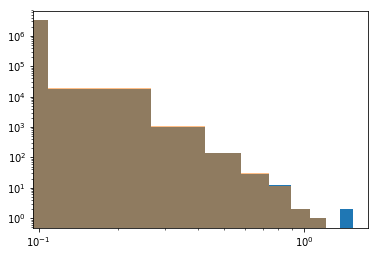

In [11]:
_,bins, _ = plt.hist(np.array(g["kappa_zs_1_ran0"]).flatten())
plt.hist(np.array(f["kappa_zs_1_ran0"]).flatten(),bins=bins,alpha = 0.5)

plt.loglog()

In [7]:
g["kappa_zs_1_ran0"].shape

(1800, 1800)

In [12]:
#importing packages, many probably won't be useful

import keras
import tensorflow as tf
from keras.layers import Conv2D,Flatten,Conv2DTranspose,concatenate
from keras.layers import Input, Dense, Lambda, concatenate,Reshape,Flatten
from keras.layers import Reshape,UpSampling2D,RepeatVector,Conv2D,MaxPool2D, AvgPool2D
from keras.layers import Dropout, BatchNormalization
from keras import optimizers

from keras.models import Model
from keras import backend as K

#channels are essentially data-fields (in case you want to map from multiple fields to one/multiple output fields)
#in this case it goes (# of data entries, channels, x, y), as opposed to (# of data entries, x, y, channels)
keras.backend.set_image_data_format('channels_first')


In [41]:
#layers definitions, very minimal, one "skip" connection


l1 = Conv2D(5,3,padding="same",activation="selu")#can play around alot with activations!
l2 = Conv2D(8,3,padding="same",activation="selu")
l3 = Conv2D(16,3,padding="same",activation="tanh")
l4 = Conv2D(8,3,padding="same",activation="selu")
l5 = Conv2D(2,3,padding="same",activation="selu")
l6 = Conv2D(1,2,padding="same",activation="tanh")


#setting up the "flow" of the network
x_in = Input(shape=(5,1800, 1800),name="field")

x = l1(x_in)
x = l2(x)
x = l3(x)
x = l4(x)

x = concatenate([x,x_in],axis=1) #skip connection

x = l5(x)
x = l6(x)

#defining start point and end point of model
simple = Model(x_in, x)

#checking output shape is correct
print(x.shape)


(?, 1, 1800, 1800)


In [42]:
simple.summary() #very "small" model by neural network standards

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
field (InputLayer)              (None, 5, 1800, 1800 0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 5, 1800, 1800 230         field[0][0]                      
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 8, 1800, 1800 368         conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 16, 1800, 180 1168        conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_58 

In [43]:
#optimizer choice, Adam is the current fan favorite. Currently using the default parameters for it.
#Adam uses "momentum information" to smooth out optimization...
adam = optimizers.SGD(lr=0.0001)



In [44]:
from keras import objectives
#defining objective function and optimizer to use
simple.compile(optimizer=adam,loss=objectives.mean_squared_error)


In [ ]:
#quicky fitting
xfield = np.array(g["kappa_zs_1_ran0"]).reshape(1,1,1800,1800)
yfield = np.array(f["kappa_zs_1_ran0"]).reshape(1,1,1800,1800)

#extracting some features... currently just the smoothed map at a variety of scales...
xfield2 = ndimage.gaussian_filter(xfield,5)
xfield3 = ndimage.gaussian_filter(xfield,10)
xfield4 = ndimage.gaussian_filter(xfield,25)
xfield5 = ndimage.gaussian_filter(xfield,50)

xfield_n = np.hstack([xfield,xfield2,xfield3,xfield4,xfield5])

print(xfield_n.shape) #note there are now five channels!

simple.fit(x=xfield_n,y=yfield,batch_size=1,epochs=1000)

(1, 5, 1800, 1800)
Epoch 1/1000
1/1 [==============================] - 22s 22s/step - loss: 0.0014
Epoch 2/1000
1/1 [==============================] - 22s 22s/step - loss: 0.0014
Epoch 3/1000
1/1 [==============================] - 22s 22s/step - loss: 0.0014
Epoch 4/1000
1/1 [==============================] - 22s 22s/step - loss: 0.0014
Epoch 5/1000
1/1 [==============================] - 40s 40s/step - loss: 0.0014
Epoch 492/1000
1/1 [==============================] - 26s 26s/step - loss: 0.0014
Epoch 493/1000
1/1 [==============================] - 28s 28s/step - loss: 0.0014
Epoch 494/1000


In [ ]:
output = simple.predict(xfield_n)

In [39]:
np.sum((output[0,0]-np.array(f["kappa_zs_1_ran0"]))**2.0)/np.sum((np.array(g["kappa_zs_1_ran0"])-np.array(f["kappa_zs_1_ran0"]))**2.0)



0.74665475

In [ ]:
plt.figure(figsize=(10,10))

imshow(output[0,0]-np.array(f["kappa_zs_1_ran0"]),vmin=-0.1,vmax=0.1)
colorbar()
plt.show()


plt.figure(figsize=(10,10))

imshow(np.array(g["kappa_zs_1_ran0"])-np.array(f["kappa_zs_1_ran0"]),vmin=-0.1,vmax=0.1)
colorbar()
plt.show()